In [345]:
from tools.utils import *
from tools.het_networks import *
from itertools import product

import torch

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [346]:
# Random
seed = 42

# Model
hidden_channels = 256
num_classes = 6
num_layers = 2
intra_aggr='sum'
inter_aggr='mean'
dropout = 0.6
use_skip_connections = True
batch_size = 8
epochs = 45
decay = 2.5e-4
lr = 5e-4
maxlr = 5e-4

# Preprocessing

In [347]:
# Load the ENZYMES dataset
hom_dataset = TUDataset(root='data', name='ENZYMES')                          # This has 3 one-hot encodings
hom_dataset_attr = TUDataset(root='data', name='ENZYMES', use_node_attr=True) # This has 3 one-hot encodings and 18 features

In [348]:
def normalize_enzymes_data(data):
    data = data.clone()
    if hasattr(data, 'x') and data.x is not None:
        x = data.x
        feats = x[:, :18]
        mean = feats.mean(dim=0)
        std = feats.std(dim=0, unbiased=False)
        std[std == 0] = 1.0
        normalized_feats = (feats - mean) / std
        x[:, :18] = normalized_feats
        data.x = x
    return data

# Normalize features
normalized_hom_dataset_attr = [normalize_enzymes_data(hom_data) for hom_data in hom_dataset_attr]

In [349]:
# Construct het dataset
het_dataset = []
for hom_data in normalized_hom_dataset_attr:
    het_data = convert_hom_to_het(hom_data, onehot_indices=[18, 19, 20], is_directed=False)
    het_dataset.append(het_data)
het_dataset.__len__()

600

In [350]:
# Get the metadata to build HeteroGNN
edge_types = het_dataset[0].edge_types
node_types = het_dataset[0].node_types
metadata = (node_types, edge_types)
metadata

(['A', 'B', 'C'],
 [('A', 'edge_index', 'A'),
  ('A', 'edge_index', 'B'),
  ('A', 'edge_index', 'C'),
  ('B', 'edge_index', 'B'),
  ('B', 'edge_index', 'C'),
  ('C', 'edge_index', 'C')])

In [351]:
# Create splits
labels = [data.y.item() for data in het_dataset]

train_set, temp_set = train_test_split(
    het_dataset, 
    test_size=0.3, 
    stratify=labels,
    random_state=seed
    
)

temp_labels = [data.y.item() for data in temp_set]
valid_set, test_set = train_test_split(
    temp_set, 
    test_size=0.5, 
    stratify=temp_labels,
    random_state=seed
)

# train_loader is defined at each experiment for reproducibility
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Tuning HeteroGNN

Epoch 1/45
Train Loss: 1.8053 | Validation Loss: 1.7973
Train Acc: 0.1714 | Validation Acc: 0.1556
Train F1: 0.1323 | Validation F1: 0.0453

Epoch 2/45
Train Loss: 1.8071 | Validation Loss: 1.7927
Train Acc: 0.1738 | Validation Acc: 0.1000
Train F1: 0.1665 | Validation F1: 0.0809

Epoch 3/45
Train Loss: 1.7861 | Validation Loss: 1.7882
Train Acc: 0.1881 | Validation Acc: 0.2222
Train F1: 0.1781 | Validation F1: 0.1594

Epoch 4/45
Train Loss: 1.7911 | Validation Loss: 1.7795
Train Acc: 0.1762 | Validation Acc: 0.2889
Train F1: 0.1579 | Validation F1: 0.2416

Epoch 5/45
Train Loss: 1.7678 | Validation Loss: 1.7661
Train Acc: 0.2167 | Validation Acc: 0.2444
Train F1: 0.1978 | Validation F1: 0.1681

Epoch 6/45
Train Loss: 1.7612 | Validation Loss: 1.7606
Train Acc: 0.2357 | Validation Acc: 0.2111
Train F1: 0.2306 | Validation F1: 0.1469

Epoch 7/45
Train Loss: 1.7243 | Validation Loss: 1.7479
Train Acc: 0.2929 | Validation Acc: 0.1667
Train F1: 0.2735 | Validation F1: 0.1447

Epoch 8/45
Tr

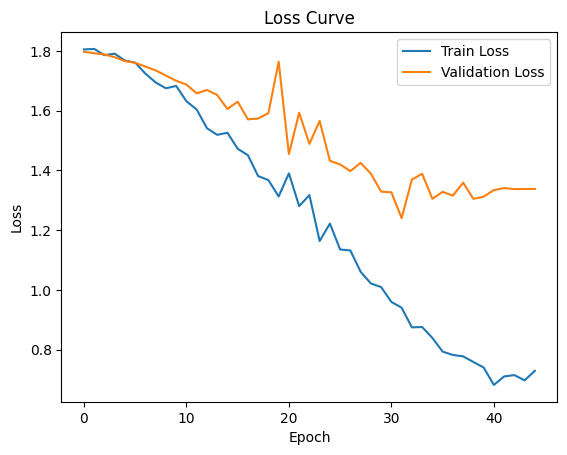

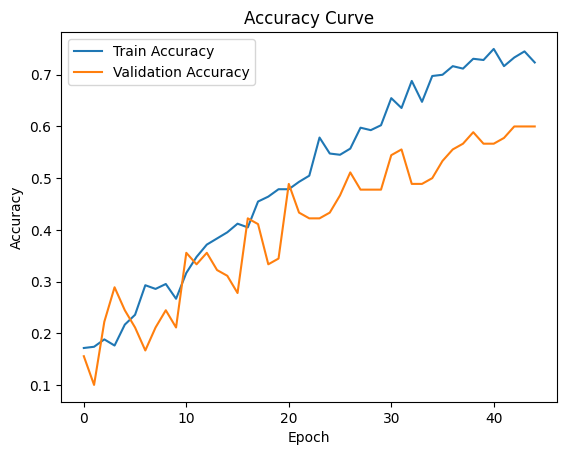

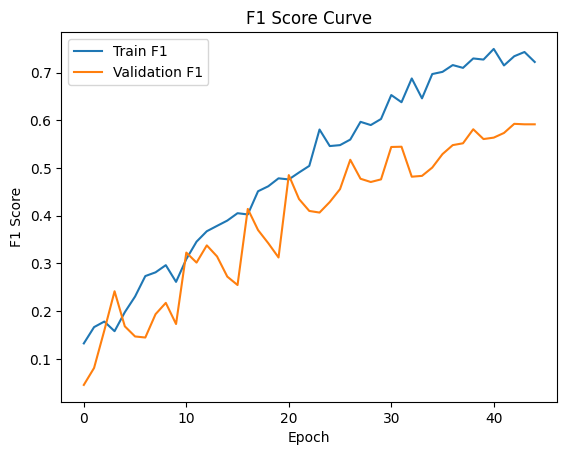

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.8053,1.7973,0.1714,0.1556,0.1323,0.0453
1,2,1.8071,1.7927,0.1738,0.1000,0.1665,0.0809
2,3,1.7861,1.7882,0.1881,0.2222,0.1781,0.1594
3,4,1.7911,1.7795,0.1762,0.2889,0.1579,0.2416
4,5,1.7678,1.7661,0.2167,0.2444,0.1978,0.1681
5,6,1.7612,1.7606,0.2357,0.2111,0.2306,0.1469
6,7,1.7243,1.7479,0.2929,0.1667,0.2735,0.1447
7,8,1.6948,1.7351,0.2857,0.2111,0.2813,0.1936
8,9,1.6752,1.7179,0.2952,0.2444,0.2963,0.2173
9,10,1.6831,1.7005,0.2667,0.2111,0.2613,0.1730


In [ ]:
experiment_name = f"ENZYMES-HeteroGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{intra_aggr} intra_aggr-{inter_aggr} inter_aggr-{dropout} dropout-use skip {use_skip_connections}-{lr} lr-{maxlr} maxlr-{decay} decay-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HeteroGNN_GraphConv(metadata, hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, intra_aggr=intra_aggr, inter_aggr=inter_aggr, dropout=dropout, use_skip_connections=use_skip_connections).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
criterion = torch.nn.CrossEntropyLoss()
model
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, het_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, het_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)